# Zápočtová úloha – Úloha 1: SIR model
*Autor: Zdeněk Touška*

Tento sešit implementuje **SIR model** šíření infekce pro pět konkrétních onemocnění.  

> Zadání úlohy požaduje:
> 1. Převést rovnice modelu do Pythonu (využívám `numpy` a integrátor `scipy.integrate.solve_ivp`, stejně
>    jako to má kamarád ve svém zápočtu).
> 2. Vybrat **5 nemocí** a pro každou zjistit:
>    * den, kdy nastane vrchol epidemie,
>    * délku epidemie,
>    * celkový počet nakažených.
> 3. Každý graf je vykreslen **ve vlastní buňce**.


## 1 · Importy a globální nastavení

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


## 2 · Definice rovnic SIR a pomocných funkcí

In [ ]:
# Funkce popisující SIR systém
def sir_system(t, y, beta, gamma, N):   # přenosová konstanta, rychlost uzdravování, celková populace
    s, i, r = y  # náchylní, nakažení, uzdravení  y je kolekce [S, I, R], která obsahuje předešlé hodnoty
    dsdt = -beta * s * i / N        #derivace S podle času
    didt = beta * s * i / N - gamma * i   # derivace I podle času
    drdt = gamma * i # derivace R podle času
    return [dsdt, didt, drdt]       #používá se v solve_ivp

def run_sir_simulation(name, R0, infectious_days, population=1_000_000, initially_infected=10):
    """Spustí simulaci pro zadané onemocnění a vrátí výstupy i statistiky."""
    gamma = 1 / infectious_days          # rychlost uzdravování
    beta  = R0 * gamma                  # přenosová konstanta odvozená z R0
    
    # R0 je základní reprodukční číslo, které udává průměrný počet nakažených osob jednou nakaženou osobou

    # Počáteční podmínky
    S0 = population - initially_infected  # náchylní
    I0 = initially_infected              # nakažení
    R0_ = 0                              # uzdravení

    N = population                       # celková populace
    t_eval = np.linspace(0, 365, 366)    # simulace na rok (denní krok) 

    sol = solve_ivp(        #řešení soustavy diferenciálních rovnic
        fun=lambda t, y: sir_system(t, y, beta, gamma, N),  #funkce o proměnných t, y, využívající sir_system
        t_span=(t_eval[0], t_eval[-1]),  #? počáteční a koncový čas/bod
        y0=[S0, I0, R0_],   #implementace počátečních podmínek
        t_eval=t_eval,      #? časové body, ve kterých chceme výstup
        dense_output=True,      #nutná věc pro interpolaci výsledků
    )

    S, I, R = sol.y   # S, I, R jsou výsledky z řešení soustavy diferenciálních rovnic
    # I je počet nakažených 
    # Statistika vrcholu – hledáme max(I)
    peak_idx = np.argmax(I) #uplne maximum v I
    peak_day = int(t_eval[peak_idx])    #uplne maximum v I, den, kdy k tomu došlo

    # Konec epidemie – první den, kdy I < 1
    remaining_infected = I.copy()
    end_day = next((int(t_eval[idx]) for idx, val in enumerate(remaining_infected) if val < 1), t_eval[-1]) 
    
    
    total_infected = int(R[-1])  # koncový stav R je počet, co prošli infekcí

    stats = {
        'name': name,
        'peak_day': peak_day,
        'duration': end_day,
        'total_infected': total_infected,
    }
    return t_eval, S, I, R, stats


## 3 · Parametry pěti vybraných nemocí

In [ ]:
# Hodnoty R₀ a délka infekčnosti (v dnech) – orientačně z literatury / Wikipedie
diseases = [
    {'name': 'Chřipka',          'R0': 1.3,  'inf_days': 5},
    {'name': 'COVID‑19 (Alfa)',  'R0': 2.8,  'inf_days': 7},
    {'name': 'Spalničky',        'R0': 15,   'inf_days': 8},
    {'name': 'Ebola',            'R0': 1.8,  'inf_days': 10},
    {'name': 'Malárie',          'R0': 3.0,  'inf_days': 30},
]

results = []
for idx, dis in enumerate(diseases):
    t_eval, S, I, R, st = run_sir_simulation(dis['name'], dis['R0'], dis['inf_days'])
    results.append(st)


## 4 · Shrnutí výsledků
Níže je tabulka se třemi požadovanými údaji pro každé onemocnění.

In [5]:
import pandas as pd
summary_df = pd.DataFrame(results)
summary_df = summary_df[['name', 'peak_day', 'duration', 'total_infected']]
display(summary_df)

,name,peak_day,duration,total_infected
0,Chřipka,158,365.0,423569
1,COVID‑19 (Alfa),47,166.0,924651
2,Spalničky,8,118.0,999999
3,Ebola,138,365.0,729551
4,Malárie,184,365.0,934508


## 5 · Vizualizace průběhu – každý graf v samostatné buňce

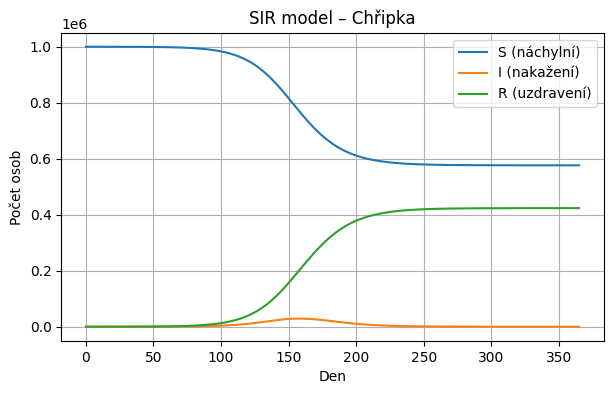

In [ ]:
# Graf pro Chřipka
d = next(item for item in results if item['name'] == 'Chřipka') # vybereme si konkrétní nemoc
# a použijeme ji pro vykreslení grafu
# Vykreslíme SIR model pro Chřipku
# Použijeme hodnoty z diseases, které odpovídají Chřipce
# a použijeme je pro vykreslení grafu
t_eval, S, I, R, _ = run_sir_simulation(d['name'], next(d2['R0'] for d2 in diseases if d2['name']==d['name']),
                                           next(d2['inf_days'] for d2 in diseases if d2['name']==d['name']))
plt.figure(figsize=(7,4))
plt.plot(t_eval, S, label='S (náchylní)')
plt.plot(t_eval, I, label='I (nakažení)')
plt.plot(t_eval, R, label='R (uzdravení)')
plt.title('SIR model – Chřipka')
plt.xlabel('Den')
plt.ylabel('Počet osob')
plt.legend()
plt.grid(True)
plt.show()

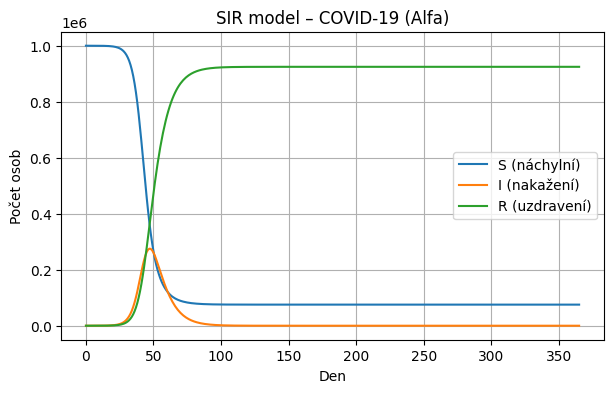

In [7]:
# Graf pro COVID‑19 (Alfa)
d = next(item for item in results if item['name'] == 'COVID‑19 (Alfa)')
t_eval, S, I, R, _ = run_sir_simulation(d['name'], next(d2['R0'] for d2 in diseases if d2['name']==d['name']),
                                           next(d2['inf_days'] for d2 in diseases if d2['name']==d['name']))
plt.figure(figsize=(7,4))
plt.plot(t_eval, S, label='S (náchylní)')
plt.plot(t_eval, I, label='I (nakažení)')
plt.plot(t_eval, R, label='R (uzdravení)')
plt.title('SIR model – COVID‑19 (Alfa)')
plt.xlabel('Den')
plt.ylabel('Počet osob')
plt.legend()
plt.grid(True)
plt.show()

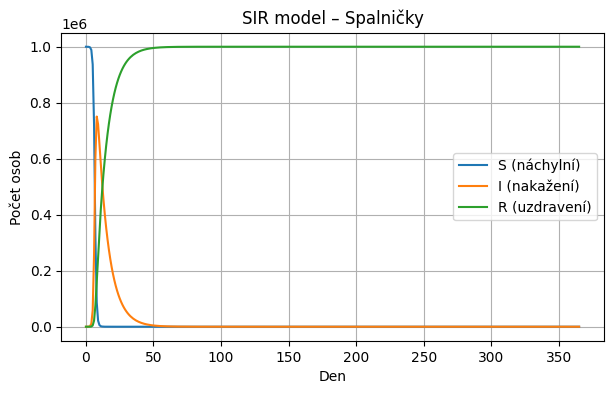

In [8]:
# Graf pro Spalničky
d = next(item for item in results if item['name'] == 'Spalničky')
t_eval, S, I, R, _ = run_sir_simulation(d['name'], next(d2['R0'] for d2 in diseases if d2['name']==d['name']),
                                           next(d2['inf_days'] for d2 in diseases if d2['name']==d['name']))
plt.figure(figsize=(7,4))
plt.plot(t_eval, S, label='S (náchylní)')
plt.plot(t_eval, I, label='I (nakažení)')
plt.plot(t_eval, R, label='R (uzdravení)')
plt.title('SIR model – Spalničky')
plt.xlabel('Den')
plt.ylabel('Počet osob')
plt.legend()
plt.grid(True)
plt.show()

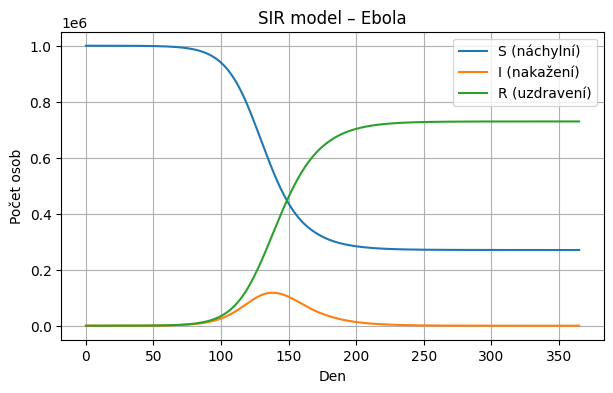

In [9]:
# Graf pro Ebola
d = next(item for item in results if item['name'] == 'Ebola')
t_eval, S, I, R, _ = run_sir_simulation(d['name'], next(d2['R0'] for d2 in diseases if d2['name']==d['name']),
                                           next(d2['inf_days'] for d2 in diseases if d2['name']==d['name']))
plt.figure(figsize=(7,4))
plt.plot(t_eval, S, label='S (náchylní)')
plt.plot(t_eval, I, label='I (nakažení)')
plt.plot(t_eval, R, label='R (uzdravení)')
plt.title('SIR model – Ebola')
plt.xlabel('Den')
plt.ylabel('Počet osob')
plt.legend()
plt.grid(True)
plt.show()

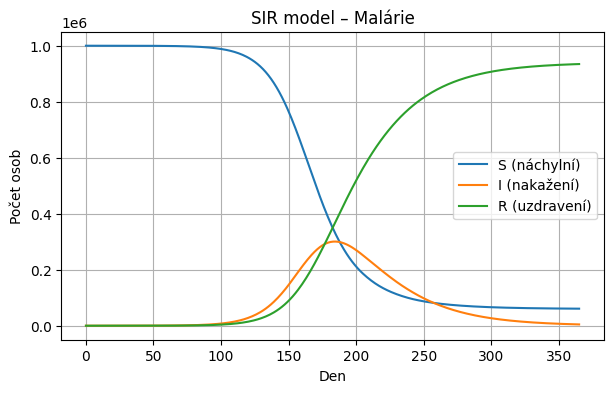

In [10]:
# Graf pro Malárie
d = next(item for item in results if item['name'] == 'Malárie')
t_eval, S, I, R, _ = run_sir_simulation(d['name'], next(d2['R0'] for d2 in diseases if d2['name']==d['name']),
                                           next(d2['inf_days'] for d2 in diseases if d2['name']==d['name']))
plt.figure(figsize=(7,4))
plt.plot(t_eval, S, label='S (náchylní)')
plt.plot(t_eval, I, label='I (nakažení)')
plt.plot(t_eval, R, label='R (uzdravení)')
plt.title('SIR model – Malárie')
plt.xlabel('Den')
plt.ylabel('Počet osob')
plt.legend()
plt.grid(True)
plt.show()

## 6 · Závěry a možné rozšíření
* epidemie s vyšším **R₀** dosahují vrcholu rychleji a postihnou větší část populace,
* změna délky infekčnosti (`inf_days`) posouvá jak vrchol, tak celkovou délku epidemie,
* v praxi je model zjednodušený – nezohledňuje například očkování ani demografii.

